In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
DENSE = False
EPS = 60
LAG = 24 + 1
# SROUTE = [
#     '403259-401851', 
#     '401851-401852'
# ]
SROUTE = [
    '400860-400861', 
    '400861-403781',
#     '400861-400948',
    '400861-405376',
]
STOPS = len(SROUTE)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
dset = SpotHistory(SROUTE, 'train', 32, lag=LAG, res=10).generator()
evalset = SpotHistory(SROUTE, 'test', 32, lag=LAG, res=10).generator()

Chunks (lag 25)
 [*] Segments: 90 co-avail
    * [400860-400861]: 90
    * [400861-403781]: 90
    * [400861-405376]: 90
 [*] Examples (train): 8167
 [*] Time range: 2014-08-01 ~ 2014-10-31
Chunks (lag 25)
 [*] Segments: 90 co-avail
    * [400860-400861]: 90
    * [400861-403781]: 90
    * [400861-405376]: 90
 [*] Examples (test): 2058
 [*] Time range: 2014-08-01 ~ 2014-10-31


In [7]:
from models.Linear import *
model = Linear(lag=LAG-1, stops=STOPS).to(device)
model.device = device
criterion, opt, sch = model.params(lr=0.005)

In [8]:
evf = lambda: evaluate(
    evalset, model, 
    crit=lambda _y, y: criterion(_y[:, 0], y[:, 0]).item())
_ = evf()

Eval loss: 121.1730          


In [9]:
losses = []
eval_mse = []
eval_mape = []

for eii  in range(EPS):
    bls = []
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        bls.append(loss.item())
        sys.stdout.write('[%d/%d : %d/%d] - L%.2f %s      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            10**2 * loss.item(),
            '(avg %.2f)' % (10 ** 2 * np.mean(bls)) if bii == len(dset) -1 else ''
        ))
    sys.stdout.write('\n')

    eval_mse.append(evf())
    sys.stdout.flush()
    sch.step()

[1/60 : 256/256] - L0.61 (avg 3.00)      
Eval loss: 1.5815          
[2/60 : 256/256] - L0.68 (avg 1.05)      
Eval loss: 1.2007          
[3/60 : 256/256] - L0.36 (avg 0.76)      
Eval loss: 0.7732          
[4/60 : 256/256] - L0.13 (avg 0.62)      
Eval loss: 0.5615          
[5/60 : 256/256] - L0.29 (avg 0.49)      
Eval loss: 0.5154          
[6/60 : 256/256] - L0.27 (avg 0.43)      
Eval loss: 0.4334          
[7/60 : 256/256] - L0.32 (avg 0.41)      
Eval loss: 0.3980          
[8/60 : 256/256] - L0.61 (avg 0.35)      
Eval loss: 0.7276          
[9/60 : 256/256] - L0.15 (avg 0.33)      
Eval loss: 0.3146          
[10/60 : 256/256] - L0.82 (avg 0.32)      
Eval loss: 0.2642          
[11/60 : 256/256] - L0.35 (avg 0.29)      
Eval loss: 0.2567          
[12/60 : 256/256] - L0.16 (avg 0.27)      
Eval loss: 0.2368          
[13/60 : 256/256] - L0.29 (avg 0.27)      
Eval loss: 0.3133          
[14/60 : 256/256] - L0.13 (avg 0.26)      
Eval loss: 0.2160          
[15/60 : 256/25

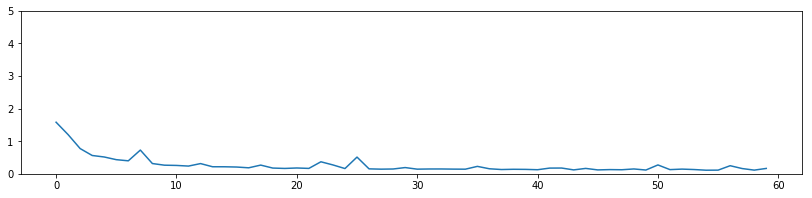

In [10]:
plt.figure(figsize=(14, 3))
plt.plot(eval_mse); plt.ylim(0, 5)
plt.show(); plt.close()

In [11]:
from utils import *
viewset = SpotHistory(SROUTE, 'test', 18, lag=None, res=10, shuffle=False, verbose=False)
mses = []

sqerr = eval_lin(viewset, model, test_lag=LAG-1, fmax=10, plot=False)
print('Eval segments:', len(viewset))
print('Eval MSE: %.4f' % np.mean(sqerr))

Eval segments: 18
Eval MSE: 0.1650


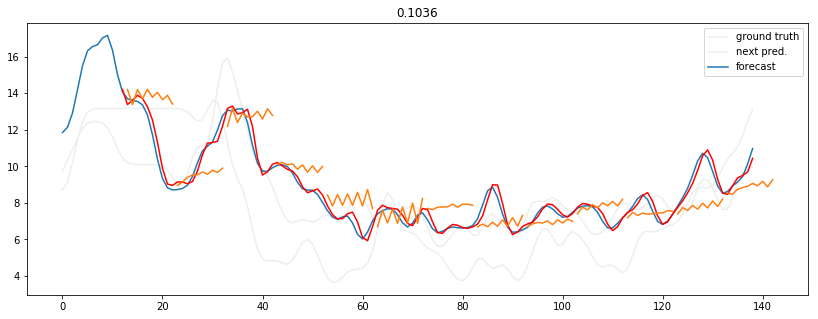

In [15]:
_ = eval_lin(viewset[:1], model, test_lag=LAG-1, fmax=10, plot=True)

In [16]:
# torch.save(model.state_dict(), 'checkpoints/lin_h1.pth')